# Sourcing and grouping RSS feeds

There's a lot of focus nowadays on webscraping for information retrieval, but before web-scraping and its questionable ethics there already existed a solution for computer-readable news data.

RSS (Rich Site Summary) feeds publish frequently updated information on the news/pages/documents available from a site.  The RSS document (an xml kind of thing) contains a headline, summary description (usually just one sentence), a picture and a link to the full article or document.  RSS systems are used in RSS reader software and other news aggregation apps to provide information on available stories while minimising overhead (eg; an app for browsing news articles doesn't have to retrieve and load every article/web page in full, just the much smaller amount of information in the RSS document).

So I can use them to create a corpus of summarized news items right?

Info on how to get the RSS docs from https://www.pythonforbeginners.com/feedparser/using-feedparser-in-python

In [2]:
import feedparser
import json
import datetime
import nltk

import numpy as np
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag

# For the spacy run
import spacy
from spacy import displacy
from collections import Counter

# Load the english language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [41]:
# These only need running once on your pc!
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ozzy/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

### The BBC feed
Is a fairly straight-forward example

In [2]:
bbc = feedparser.parse("http://feeds.bbci.co.uk/news/rss.xml")

In [3]:
bbc.keys()

dict_keys(['feed', 'entries', 'bozo', 'headers', 'href', 'status', 'encoding', 'version', 'namespaces'])

In [4]:
len(bbc['entries'])

45

In [5]:
for article in bbc['entries']:
    print(article['title'], article['summary'], article['links'][0]['href'])

Prince Philip: Sandringham crash led to car 'tumbling' across road The royal was shaken after being freed from his Land Rover, an eyewitness to Thursday's crash says. https://www.bbc.co.uk/news/uk-46918039
Buzzfeed report that Trump 'instructed Cohen to lie' sparks outcry Democrats say they will investigate a report the president instructed his ex-lawyer to lie to Congress. https://www.bbc.co.uk/news/world-us-canada-46915909
Leicester explosion: Three men jailed for murdering five people Five people - including a mother and her two sons - were killed in the insurance scam explosion. https://www.bbc.co.uk/news/uk-england-leicestershire-46865455
Australia swelters through record-breaking heatwave The country has just experienced five of its 10 warmest days on record, meteorologists say. https://www.bbc.co.uk/news/world-australia-46886798
Liam Fox: Customs union 'would not deliver Brexit' Liam Fox says the UK could not have an independent trade policy if in a customs arrangement with the 

### The Reuters feed
Includes a lot of formatting information within the summary field, which is a pain in the ass.  Solved by splitting on "<"

In [6]:
reu = feedparser.parse("http://feeds.reuters.com/Reuters/worldNews")

In [7]:
len(reu['entries'])

20

In [8]:
for article in reu['entries']:
    print(article['title'], article['summary'].split("<")[0], article['links'][0]['href'])

UK PM May to discuss Brexit next steps with ministers, EU leaders British Prime Minister Theresa May will hold a series of meetings with some of her top ministers on Friday to discuss the way forward on Brexit after her deal with Brussels was rejected by parliament, her spokeswoman said. http://feeds.reuters.com/~r/Reuters/worldNews/~3/t1hB8P6mgUk/uk-pm-may-to-discuss-brexit-next-steps-with-ministers-eu-leaders-idUSKCN1PC17C
Bulgaria detains 43 people in raids on suspected terrorist financing ring Bulgarian special police forces arrested 43 people on Friday in coordinated raids across the country on a suspected terrorism financing ring. http://feeds.reuters.com/~r/Reuters/worldNews/~3/Hm-GiY5_Bws/bulgaria-detains-43-people-in-raids-on-suspected-terrorist-financing-ring-idUSKCN1PC1WA
Israeli museum to drop 'McJesus' sculpture after protests An Israeli museum plans to withdraw a sculpture depicting the McDonald's mascot as the crucified Jesus following protests which briefly united the c

## 1. Parsing lots of feeds!

Each of these feeds only gives a set number of news stories (to limit overhead/abuse I guess) so lets parse lots of different feeds and build a news corpus.

Lots of different country's world news sites - I sourced all the links from this blog;
https://blog.feedspot.com/world_news_rss_feeds/

In [9]:
feeds = ["http://feeds.bbci.co.uk/news/world/rss.xml",
         "http://feeds.reuters.com/Reuters/worldNews",
         "http://www.cbn.com/cbnnews/world/feed/",
         "https://news.google.com/news/rss/headlines/section/topic/WORLD?ned=us&hl=en",
         "https://www.reddit.com/r/worldnews/.rss"
         "https://www.nytimes.com/svc/collections/v1/publish/https://www.nytimes.com/section/world/rss.xml",
         "https://www.buzzfeed.com/world.xml",
         "http://www.aljazeera.com/xml/rss/all.xml",
         "http://defence-blog.com/feed",
         "http://www.e-ir.info/category/blogs/feed",
         "http://www.globalissues.org/news/feed",
         "https://www.thecipherbrief.com/feed",
         "http://feeds.feedburner.com/WarNewsUpdates",
         "https://www.yahoo.com/news/world/rss",
         "https://www.theguardian.com/world/rss",
         "http://feeds.washingtonpost.com/rss/world",
         "http://timesofindia.indiatimes.com/rssfeeds/296589292.cms",
         "http://feeds.feedburner.com/ndtvnews-world-news",
         "https://www.rt.com/rss/news",
         "http://www.independent.co.uk/news/world/rss",
         "http://www.spiegel.de/international/index.rss",
         "http://www.npr.org/rss/rss.php?id=1004",
         "http://feeds.feedburner.com/daily-express-world-news",
         "https://www.cnbc.com/id/100727362/device/rss/rss.html",
         "http://www.mirror.co.uk/news/world-news/rss.xml",
         "http://www.cbc.ca/cmlink/rss-world",
         "https://www.cbsnews.com/latest/rss/world",
         "https://www.thesun.co.uk/news/worldnews/feed",
         "http://www.latimes.com/world/rss2.0.xml",
         "https://sputniknews.com/export/rss2/world/index.xml",
         "http://abcnews.go.com/abcnews/internationalheadlines",
         "http://www.abc.net.au/news/feed/52278/rss.xml",
         "https://www.vox.com/rss/world/index.xml",
         "http://feeds.skynews.com/feeds/rss/world.xml",
         "http://www.smh.com.au/rssheadlines/world/article/rss.xml",
         "http://en.rfi.fr/general/rss",
         "http://feeds.news24.com/articles/news24/World/rss",
         "http://www.rawstory.com/category/world/feed",
         "http://www.euronews.com/rss?level=theme&name=news"]

In [10]:
# Parse all, drop info you don't want
corpus = []

for source in feeds:
    feed = feedparser.parse(source)
    
    for article in feed['entries']:
    
        try:
            corpus.append({"title":article['title'],                  # News titles
                           "summary":article['summary'].split("<")[0],  # payload (sans any HTML stuff)
                           "date":article['published'],
                           "link":article['links'][0]['href']})      # associated links
    
        except KeyError as e:
            print("failed on ", article, e)

print("Finished!  With {} articles".format(len(corpus)))

failed on  {'id': 'http://www.globalissues.org/news/2019/01/17/24891', 'guidislink': True, 'link': 'http://www.globalissues.org/news/2019/01/17/24891', 'title': 'Wasting & Dining: the New Water Dilemma', 'title_detail': {'type': 'text/plain', 'language': None, 'base': 'http://www.globalissues.org/news/feed', 'value': 'Wasting & Dining: the New Water Dilemma'}, 'updated': '2019-01-17T11:12:02-08:00', 'updated_parsed': time.struct_time(tm_year=2019, tm_mon=1, tm_mday=17, tm_hour=19, tm_min=12, tm_sec=2, tm_wday=3, tm_yday=17, tm_isdst=0), 'links': [{'href': 'http://www.globalissues.org/news/2019/01/17/24891', 'rel': 'alternate', 'type': 'text/html'}], 'summary': '<p><img alt="" src="http://cdn.ipsnews.net/Library/2019/01/Professor-Jan-Lundqvist_.jpg" width="640" /></p><p>STOCKHOLM, Sweden, Jan 17 (IPS)  - Professor Jan Lundqvist is Senior Advisor at the Stockholm International Water Institute (SIWI)Concerns about the supply side of food systems are shifting from insufficient production a

Finished!  With 1025 articles


In [11]:
for article in corpus:
    print(article['date'])

Fri, 18 Jan 2019 13:57:40 GMT
Fri, 18 Jan 2019 15:41:52 GMT
Fri, 18 Jan 2019 11:21:00 GMT
Fri, 18 Jan 2019 13:10:29 GMT
Fri, 18 Jan 2019 12:22:11 GMT
Fri, 18 Jan 2019 15:19:46 GMT
Fri, 18 Jan 2019 13:48:12 GMT
Fri, 18 Jan 2019 12:02:49 GMT
Fri, 18 Jan 2019 15:41:17 GMT
Fri, 18 Jan 2019 08:12:37 GMT
Fri, 18 Jan 2019 15:40:54 GMT
Fri, 18 Jan 2019 09:59:20 GMT
Fri, 18 Jan 2019 00:14:16 GMT
Thu, 17 Jan 2019 23:47:11 GMT
Thu, 17 Jan 2019 19:42:06 GMT
Thu, 17 Jan 2019 16:34:26 GMT
Thu, 17 Jan 2019 13:30:03 GMT
Thu, 17 Jan 2019 11:05:28 GMT
Wed, 16 Jan 2019 17:41:38 GMT
Fri, 18 Jan 2019 02:17:54 GMT
Fri, 18 Jan 2019 00:24:16 GMT
Wed, 16 Jan 2019 15:36:42 GMT
Mon, 14 Jan 2019 17:15:50 GMT
Fri, 11 Jan 2019 12:27:05 GMT
Fri, 18 Jan 2019 00:28:04 GMT
Thu, 17 Jan 2019 21:43:20 GMT
Thu, 17 Jan 2019 19:27:06 GMT
Fri, 18 Jan 2019 00:30:33 GMT
Fri, 18 Jan 2019 00:00:55 GMT
Fri, 18 Jan 2019 00:02:32 GMT
Fri, 18 Jan 2019 10:52:13 -0500
Fri, 18 Jan 2019 10:42:30 -0500
Fri, 18 Jan 2019 10:37:32 -0500
Fri,

In [12]:
feed['entries'][0]

{'guidislink': False,
 'id': 'http://www.euronews.com/2019/01/18/davos-elites-need-to-reassure-those-who-most-fear-our-tech-focused-future-view',
 'link': 'http://www.euronews.com/2019/01/18/davos-elites-need-to-reassure-those-who-most-fear-our-tech-focused-future-view',
 'links': [{'href': 'http://www.euronews.com/2019/01/18/davos-elites-need-to-reassure-those-who-most-fear-our-tech-focused-future-view',
   'rel': 'alternate',
   'type': 'text/html'}],
 'published': 'Fri, 18 Jan 2019 16:21:37 +0100',
 'published_parsed': time.struct_time(tm_year=2019, tm_mon=1, tm_mday=18, tm_hour=15, tm_min=21, tm_sec=37, tm_wday=4, tm_yday=18, tm_isdst=0),
 'summary': 'As the Fourth Industrial Revolution takes shape and the surge of Artificial Intelligence gathers pace, the world elites meeting at Davos need to seek to reassure those who most fear our common technological future to avoid people falling under the spell of populism.',
 'summary_detail': {'base': 'https://www.euronews.com/rss?level=the

In [13]:
# Dump the corpus to file, record the date and time in the filename
filename = "./working/RSS_corpus_{}.JSON".format(datetime.datetime.now().strftime("%Y-%m-%d %H:%M").replace(" ", "_") )

with open(filename, "w") as f:
    json.dump(corpus, f)

# 2.  Named Entity Recognition

The idea here is for every article I want a list of people/places/entities mentioned.  Not sure what use it'll be yet...

I got this code/approach/etc from; https://towardsdatascience.com/named-entity-recognition-with-nltk-and-spacy-8c4a7d88e7da

In [5]:
filename = "./working/RSS_corpus_2019-01-18_14:16.JSON"

with open(filename, "r") as f:
    corpus = json.load(f)

In [14]:
def preprocess(sent):
    sent = word_tokenize(sent)
    sent = pos_tag(sent)
    return(sent)

In [15]:
example_tagged = preprocess(corpus[0]['summary'])
example_tagged

[('Democrats', 'NNPS'),
 ('say', 'VBP'),
 ('they', 'PRP'),
 ('will', 'MD'),
 ('investigate', 'VB'),
 ('a', 'DT'),
 ('report', 'NN'),
 ('the', 'DT'),
 ('president', 'NN'),
 ('instructed', 'VBD'),
 ('his', 'PRP$'),
 ('ex-lawyer', 'NN'),
 ('to', 'TO'),
 ('lie', 'VB'),
 ('to', 'TO'),
 ('Congress', 'NNP'),
 ('.', '.')]

In [16]:
def get_names_nltk(sent):
    pattern = 'NP: {<DT>?<JJ>*<NN>}'
    cp = nltk.RegexpParser(pattern)
    cs = cp.parse(example_tagged)
    
    return(cs) # [item for item in cs if item[1].startswith("NNP")])

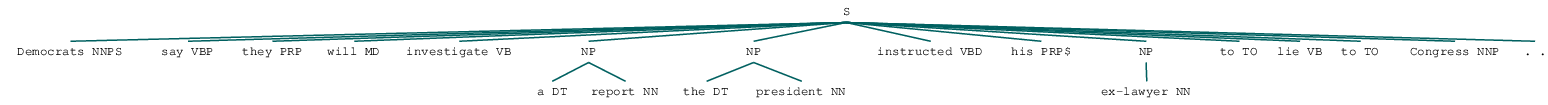

In [17]:
get_names_nltk(example_tagged)

## With Spacy

In [10]:
doc = nlp(corpus[0]['summary'])

# Am I distilling out "entities" here?  Is that what "ents" means?
print([(x.text, x.label_) for x in doc.ents])

[('Democrats', 'NORP'), ('Congress', 'ORG')]
